## TensorEncoder

In [10]:
import sys
sys.path.insert(0, '/users/fs2/hmehri/pythonproject/Thesis/synthetic')
from lib.prepare_data import preprocess_data_czech
from lib.field_info import FieldInfo,FIELD_INFO_TCODE
from lib.tensor_encoder import TensorEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import time
pd.set_option('display.max_rows', 80)

In [11]:
raw_data = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
data, LOG_AMOUNT_SCALE, TD_SCALE,ATTR_SCALE, START_DATE, field_mappings= preprocess_data_czech(raw_data)
data2 = data[['account_id','age','age_sc', 'tcode', 'tcode_num', 'datetime', 'month', 'dow', 'day','td', 'dtme', 'log_amount','log_amount_sc','td_sc',
                'type_num', 'operation_num', 'k_symbol_num']]
#data2 = data[['account_id', 'tcode_num', 'age_sc']]
df= data2.copy()


fieldinfo = FieldInfo('banksformer')
#info = FIELD_INFO_TCODE()

max_seq_len = 80
min_seq_len = 20

encoder = TensorEncoder(df, fieldinfo, max_seq_len, min_seq_len)


In [27]:
encoder.encode()

Finished encoding 2000 of 14354 seqs
Finished encoding 4000 of 14354 seqs
Finished encoding 6000 of 14354 seqs
Finished encoding 8000 of 14354 seqs
Finished encoding 10000 of 14354 seqs
Finished encoding 12000 of 14354 seqs
Finished encoding 14000 of 14354 seqs
Took 33.14 secs


In [20]:
from sklearn.model_selection import train_test_split

def create_tensor_dataset(encoder,bs, split=True):
    """bs is Batch Size
       if split=True, the input data is split into train and validation, otherwise the whole data is used for training """
    n_seqs, _, _ = encoder.inp_tensor.shape

    x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(encoder.inp_tensor, np.arange(n_seqs), encoder.tar_tensor, test_size=0.2)

def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

def create_tensor_dataset(encoder,bs, split=True):
    """bs is Batch Size
       if split=True, the input data is split into train and validation, otherwise the whole data is used for training """
    n_seqs, _, _ = encoder.inp_tensor.shape

    x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(encoder.inp_tensor, np.arange(n_seqs), encoder.tar_tensor, test_size=0.2)

    # Create TensorFlow dataset
    ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))
    ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
    ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

    BUFFER_SIZE = ds_all.cardinality().numpy()

    all_batches =   make_batches(ds_all, BUFFER_SIZE, bs)
    train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)
    val_batches =  make_batches(ds_cv, BUFFER_SIZE, bs)

    if split:
        return train_batches, val_batches
    else:
        return all_batches
    

In [22]:
batch_size = 64
train_batches, val_batches = create_tensor_dataset(encoder,batch_size, split=True)

In [23]:
train_batches

<PrefetchDataset shapes: ((None, 81, 18), (None, 80, 3)), types: (tf.float32, tf.float32)>

In [5]:
encoder.inp_tensor.shape

(14354, 81, 18)

In [5]:
add_attribute_row =  True
encoder.inp_tensor = np.zeros((encoder.n_seqs, encoder.max_seq_len, encoder.n_feat_inp))
encoder.tar_tensor = np.zeros((encoder.n_seqs, encoder.max_seq_len, encoder.n_feat_tar))
encoder.attributes = np.zeros(encoder.n_seqs)
seq_i = 0
rows_per_acct = {}
alert_every = 2000
start_time = time.time()
test_acct_id = 1
group = encoder.df[encoder.df["account_id"] == test_acct_id]
rows_per_acct[test_acct_id] = []
for i in range(len(group) // encoder.max_seq_len + 1):
    n_trs = len(group)
    start = i * encoder.max_seq_len
    seq_len = min(encoder.max_seq_len, n_trs - start)
    if seq_len >= encoder.min_seq_len:
        encoder.seq_to_inp_tensor(group.iloc[start:start + seq_len], seq_i, seq_len)
        encoder.seq_to_targ_tensor(group.iloc[start:start + seq_len], seq_i, seq_len)
        encoder.attributes[seq_i] = group["age_sc"].iloc[0]
        rows_per_acct[test_acct_id].append(seq_i)
        seq_i += 1
        if seq_i % alert_every == 0:
            print(f"Finished encoding {seq_i} of {encoder.n_seqs} seqs")
if add_attribute_row:
    encoder.inp_tensor = np.concatenate([np.repeat(encoder.attributes[:, None, None], encoder.n_feat_inp, axis=2), encoder.inp_tensor], axis=1)
    
print(f"Took {time.time() - start_time:.2f} secs")

(80, 2)
(80, 2)
(80, 2)
(80, 2)
(80, 2)
(80, 2)
(80, 2)
(80, 2)
(79, 2)
(79, 2)
(79, 2)
(79, 2)
Took 0.18 secs


In [3]:
encoder.encode()

2024-01-16 22:03:32.200161: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-16 22:03:32.201682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-16 22:03:32.229295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-01-16 22:03:32.229479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-01-16 22:03:32.229500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-16 22:0

Finished encoding 2000 of 14354 seqs
Finished encoding 4000 of 14354 seqs
Finished encoding 6000 of 14354 seqs
Finished encoding 8000 of 14354 seqs
Finished encoding 10000 of 14354 seqs
Finished encoding 12000 of 14354 seqs
Finished encoding 14000 of 14354 seqs
Took 36.98 secs


In [4]:
encoder.inp_tensor.shape

(14354, 81, 26)

## RBF and Clock transformation

In [ ]:
def bulk_encode_time_value(val, max_val):
    x = np.sin(2 * np.pi / max_val * val)
    y = np.cos(2 * np.pi / max_val * val)
    return np.stack([x, y], axis=1)
df_1 = df[df['account_id'] == 1].iloc[:80]
df_1['dow']
data_clock = bulk_encode_time_value(df_1['dow'], 7)
data_clock

In [19]:
from sklego.preprocessing import RepeatingBasisFunction
rbf = RepeatingBasisFunction(n_periods=2,
                         	column="dow",
                         	input_range=(0,6),
                         	remainder="drop")
rbf.fit(df)
data_rbf = rbf.transform(df_1)

In [8]:
data_rbf.shape

(80, 2)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

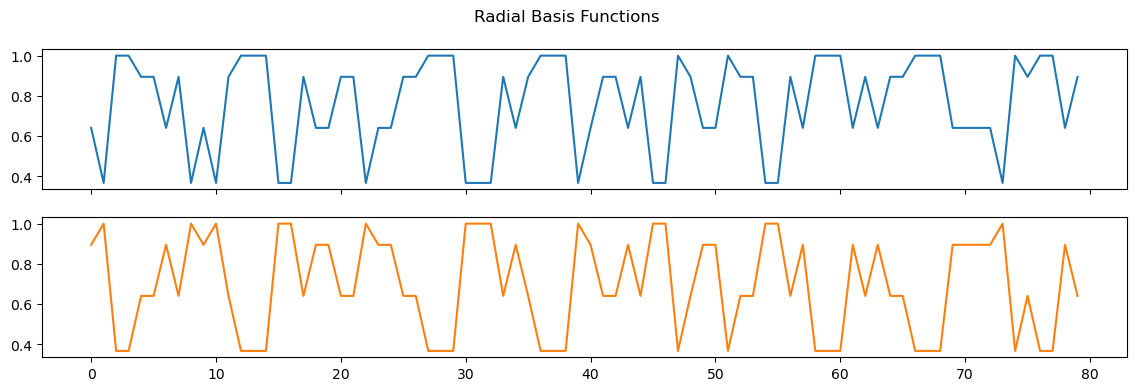

In [76]:
dow_rbf = pd.DataFrame(index = df_1.index, data=data_rbf)
dow_rbf.plot(subplots=True, figsize=(14, 4),
     	sharex=True, title="Radial Basis Functions",
     	legend=False)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

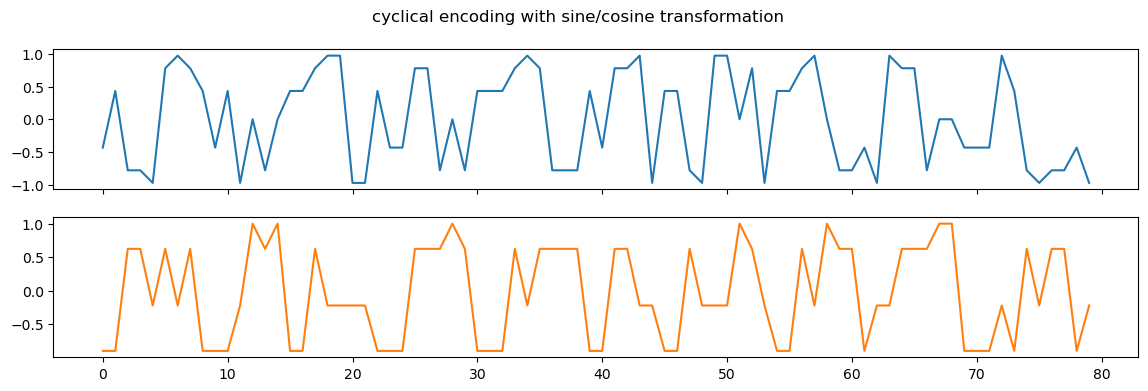

In [77]:
dow_clock = pd.DataFrame(index = df_1.index, data=data_clock)
dow_clock.plot(subplots=True, figsize=(14, 4),
     	sharex=True, title="cyclical encoding with sine/cosine transformation",
     	legend=False)

/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


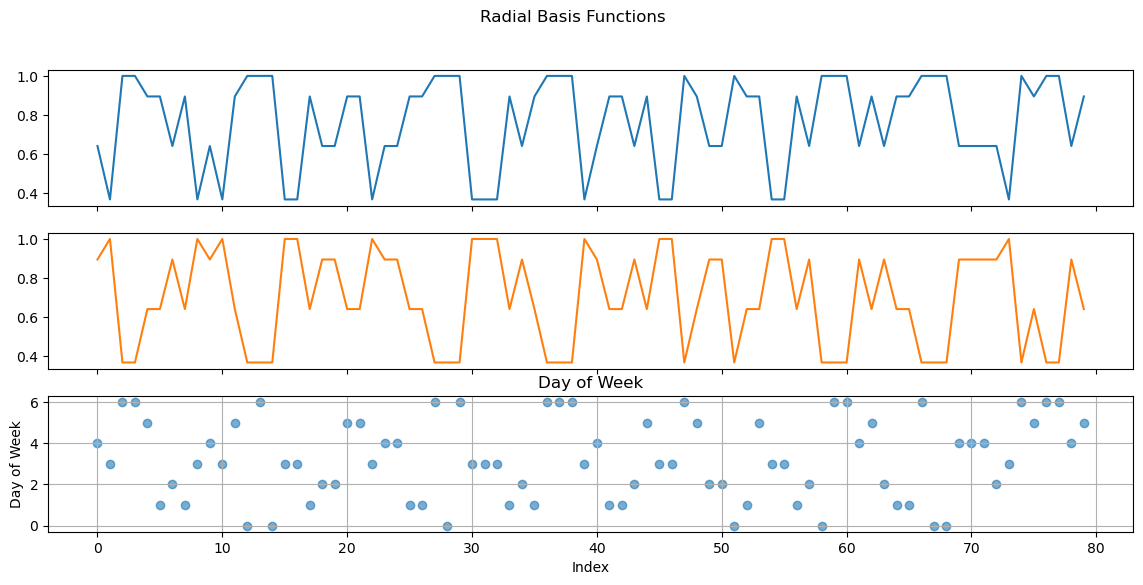

In [78]:
import matplotlib.pyplot as plt
days_of_week = df_1['dow']
dow_rbf = pd.DataFrame(index=df_1.index, data=data_rbf)
# Set up the plot - you may need to adjust figsize to fit your screen
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

# Plot the RBF data
dow_rbf.plot(subplots=True, ax=axes[:2], sharex=True, title="Radial Basis Functions", legend=False)

# Scatter plot for day of the week
# 'days_of_week' should be the same length as 'df_1.index'
axes[2].scatter(df_1.index, days_of_week, alpha=0.6)
axes[2].set_title('Day of Week')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Day of Week')
axes[2].grid(True)



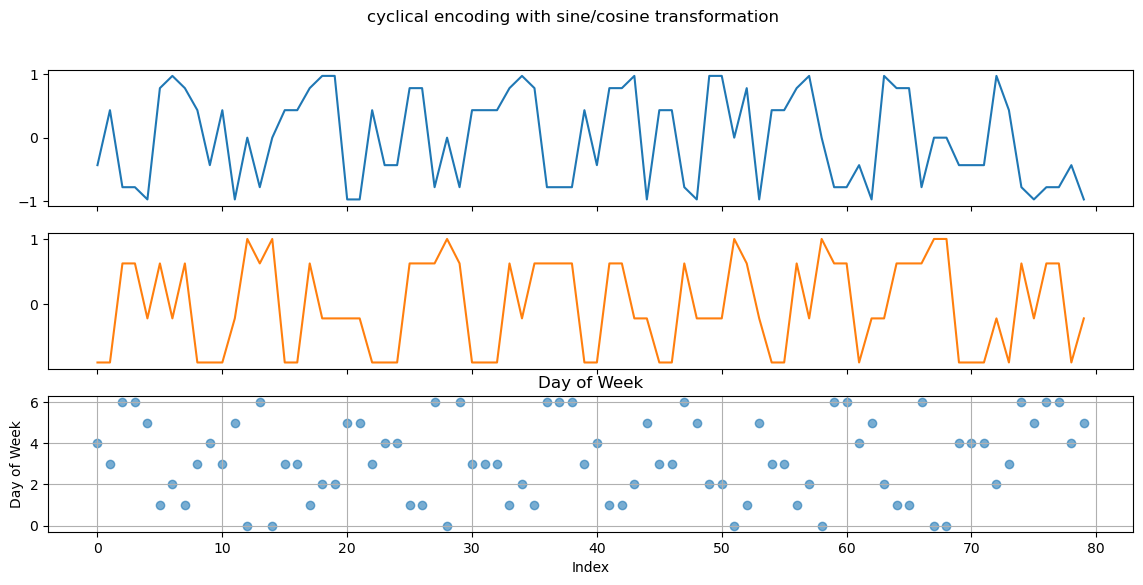

In [80]:
import matplotlib.pyplot as plt
days_of_week = df_1['dow']
dow_clock = pd.DataFrame(index=df_1.index, data=data_clock)
# Set up the plot - you may need to adjust figsize to fit your screen
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

# Plot the RBF data
dow_clock.plot(subplots=True, ax=axes[:2], sharex=True, title="cyclical encoding with sine/cosine transformation", legend=False)

# Scatter plot for day of the week
# 'days_of_week' should be the same length as 'df_1.index'
axes[2].scatter(df_1.index, days_of_week, alpha=0.6)
axes[2].set_title('Day of Week')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Day of Week')
axes[2].grid(True)


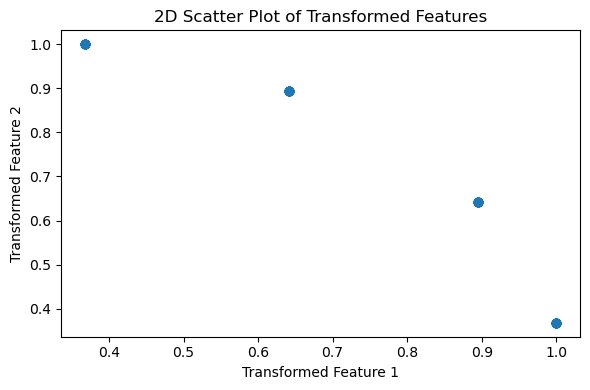

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# Scatter plot of the transformed features
axes.scatter(dow_rbf[0], dow_rbf[1])
axes.set_xlabel('Transformed Feature 1')
axes.set_ylabel('Transformed Feature 2')
axes.set_title('2D Scatter Plot of Transformed Features(RBF)')



# Adjust the layout so that the titles and labels don't overlap
plt.tight_layout()
plt.show()


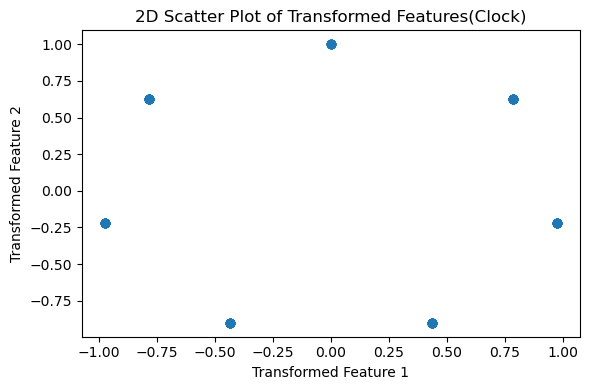

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# Scatter plot of the transformed features
axes.scatter(dow_clock[0], dow_clock[1])
axes.set_xlabel('Transformed Feature 1')
axes.set_ylabel('Transformed Feature 2')
axes.set_title('2D Scatter Plot of Transformed Features(Clock)')



# Adjust the layout so that the titles and labels don't overlap
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklego.preprocessing import RepeatingBasisFunction

def transform_rbf(array, rbf, net_name):
    """
    Transform a NumPy array using a fitted RepeatingBasisFunction and convert to a NumPy array of shape (n, num of rbf functions = 2).

    Parameters:
    array (np.array): Input NumPy array of shape (n,).
    rbf (RepeatingBasisFunction): Fitted RepeatingBasisFunction object.

    Returns:
    np.array: Transformed NumPy array of shape (n, num of rbf functions = 2).
    """
    # Convert the NumPy array to DataFrame
    df = pd.DataFrame(array, columns=[net_name])

    # Transform using the fitted RBF
    transformed_array = rbf.transform(df)

    return transformed_array

  

# Example Usage
# Assume 'rbf' is your already fitted RepeatingBasisFunction object
input_array = np.array([4, 5, 1])
transformed_array = transform_rbf(input_array, rbf, 'dow')

print(transformed_array.shape)

(3, 2)


## Train and generate data

In [6]:
def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)




In [7]:
from sklearn.model_selection import train_test_split
n_seqs, n_steps, n_feat_inp = encoder.inp_tensor.shape
x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(encoder.inp_tensor, np.arange(n_seqs), encoder.tar_tensor, test_size=0.2)

# Create TensorFlow dataset
ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))
ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

BUFFER_SIZE = ds_all.cardinality().numpy()
bs = 64  # batch size


train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)
val_batches =  make_batches(ds_cv, BUFFER_SIZE, bs)

In [8]:
from train import Train
import tensorflow as tf
from lib.modules import Transformer
import time

#fieldInfo = FieldInfo('dateonehot')
fieldInfo = FieldInfo_type2()
config = {}
config["ORDER"] = fieldInfo.DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = fieldInfo.FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = fieldInfo.FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = fieldInfo.FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = fieldInfo.FIELD_DIMS_NET
config["ACTIVATIONS"] = fieldInfo.ACTIVATIONS

n_seqs, seq_len, features = encoder.inp_tensor.shape
raw_features = encoder.tar_tensor.shape[-1]    
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4

transformer = Transformer(features,dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)


            

In [9]:
i = 1
for (batch_no, (inp, tar)) in enumerate(train_batches):
    if i == 1:
        break

In [10]:
transformer(inp, tar)

2024-01-18 20:35:11.406080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


({'tcode_num': <tf.Tensor: shape=(64, 80, 16), dtype=float32, numpy=
  array([[[ 8.7620866e-01, -1.2546309e+00, -1.0359201e+00, ...,
            3.2311779e-02, -1.6268717e+00, -6.1993718e-01],
          [ 5.7431940e-02, -1.5961373e+00, -2.3796458e+00, ...,
           -8.3196664e-01, -2.8749702e+00,  8.3983338e-01],
          [ 9.3361288e-01, -4.6950993e-01, -2.5004563e+00, ...,
           -9.2862493e-01, -3.6355731e+00,  5.0550383e-01],
          ...,
          [ 3.8259622e-02,  7.9385042e-01, -1.4715186e+00, ...,
           -4.5255372e-01, -2.8715546e+00, -7.4632621e-01],
          [-1.6575606e-01,  4.4283333e-01, -2.2174110e+00, ...,
           -2.1525641e-01, -1.8595192e+00, -3.2012102e-01],
          [-1.1427953e-01,  5.6733632e-01, -2.7470365e+00, ...,
            3.0406475e-01, -6.5847206e-01, -2.2201070e-01]],
  
         [[ 1.7049150e+00, -6.8076438e-01, -3.0252180e+00, ...,
            2.0247247e+00, -3.5421793e+00, -7.8410143e-01],
          [ 5.5033845e-01, -1.6864098e+00, -

In [13]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, None, 128)         18944     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
decoder (Decoder)            multiple                  398336    
_________________________________________________________________
dense_26 (Dense)             multiple                  16512     
_________________________________________________________________
dense_27 (Dense)             multiple                  2064      
_________________________________________________________________
dense_28 (Dense)             multiple                  290       
_________________________________________________________________
dense_29 (Dense)             multiple                  

In [11]:
epochs = 1
early_stop = 2
train = Train(transformer)
with  tf.device('/gpu:1'):
    train.train(train_batches, val_batches, epochs, early_stop)

Epoch 1 Batch0 Loss 11.3889
Epoch 1 Batch50 Loss 7.3953
Epoch 1 Batch100 Loss 6.8270
Epoch 1 Batch150 Loss 6.4941
Epoch 1 Loss 6.3423
** on validation data loss is 5.4527
Time taken for 1 epoch: 31.69 secs



In [11]:
n_feat_inp

18

In [12]:
from train import create_masks, reencode_net_prediction
def call_to_generate_type2(transformer, inp):
    x = transformer.input_layer(inp)                  
    seq_len = tf.shape(x)[1]
    x += transformer.pos_encoding[:, :seq_len, :]     #x is the output of Input layer
    x = transformer.dropout(x, training=True)
    mask, _ = create_masks(inp)
    out, attention_weights = transformer.DecoderStack(x, True, mask)
    final_output = transformer.final_layer(out)
    raw_preds = {}
    #preds is the reencoded raw_preds, 'tcode' converts to one-hot encoded, 'date-features' are converted to clock-wise
    #and for 'amount' and 'td' the predicted mean is extracted. it is used for conditional generating. 
    preds = {}
    #encoded_preds_d is similar to preds for 'tcode', 'td', and 'amount', but for date features , the predicted date is computed 
    #based on a formula 
    encoded_preds_d = {}
    #encoded_preds = []

    for net_name in transformer.ORDER:  
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        pred = reencode_net_prediction(net_name, pred, None) 
        preds[net_name] = pred
            
        encoded_preds_d[net_name] = pred[:,-1,:] 
        #encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)
    
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)   #tensor of shape (n_seqs_to_generate, 1, 26(input features))
    
    return preds, attention_weights, raw_preds, encoded_preds





In [16]:
#from train import call_to_generate_type2
import datetime
n_seqs_to_generate = 3
attributes = encoder.attributes
max_length = 25
NUM_TO_TCODE = dict([(i, tc) for i, tc in enumerate(df['tcode'].unique())])
ATTR_SCALE = df["age"].std()
seq_ages = np.random.choice(attributes, size=n_seqs_to_generate) # sample ages from real data
inp = np.repeat(np.array(seq_ages)[:, None, None], repeats=n_feat_inp, axis=2) / ATTR_SCALE   #(n_seqs_to_generate, 1, n_feat_inp) 
start_date = df.groupby("account_id")["datetime"].min()  #len = 4500
sampled_start_dates = start_date.sample(n_seqs_to_generate)

        

for i in range(max_length):     
    predictions, attn, raw_ps, enc_preds = call_to_generate_type2(transformer, inp)
    #print(date_inds)
    enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))      #(n_seqs_to_generate, 1, n_feat_inp)
    inp = tf.concat([inp, enc_preds], axis=1)   
    print(inp.shape)

FIELD_STARTS_IN = fieldInfo.FIELD_STARTS_IN
FIELD_DIMS_IN = fieldInfo.FIELD_DIMS_IN

seqs = inp
seqs = inp
ages = seqs[:, 0, :] * ATTR_SCALE
seqs = seqs[:, 1:, :]
assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"

amts = seqs[:, :, FIELD_STARTS_IN["log_amount_sc"]].numpy() * LOG_AMOUNT_SCALE
amts = 10 ** amts
amts = np.round(amts - 1.0, 2)
days_passed = np.round(seqs[:, :, FIELD_STARTS_IN["td_sc"]] * TD_SCALE ).astype(int)

t_code = np.argmax(seqs[:, :, FIELD_STARTS_IN["tcode_num"]: FIELD_STARTS_IN["tcode_num"] + FIELD_DIMS_IN["tcode_num"]], axis=-1)
flattened_amts = amts.flatten()

flattened_tcodes = t_code.flatten()

flattened_td = days_passed.flatten()


translated_tcodes = [NUM_TO_TCODE[code] for code in flattened_tcodes]

df_synth = pd.DataFrame({
    'amount': flattened_amts,
    'tcode': translated_tcodes,
    'td': flattened_td

})
 # Handling account IDs
num_customers = amts.shape[0]
num_transactions = amts.shape[1]
account_ids = np.repeat(range(num_customers), num_transactions)
df_synth['account_id'] = account_ids

# Identify the first transaction for each account
first_transactions = df_synth.groupby('account_id').head(1).index
# Set 'td' to 0 only for the first transactions
df_synth.loc[first_transactions, 'td'] = 0

df_synth['cumulative_td'] = df_synth.groupby('account_id')['td'].cumsum()

for i, account_id in enumerate(df_synth['account_id'].unique()):
    start_date_str = sampled_start_dates.iloc[i].strftime('%Y-%m-%d')
    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')

    # Filter the rows for the current account_id
    account_rows = df_synth[df_synth['account_id'] == account_id]

    # Calculate the date for each transaction
    for index, row in account_rows.iterrows():
        if index == 0:
            df_synth.at[index, 'td'] = 0
            df_synth.at[index, 'datetime'] = start_date
        else:
            transaction_date = start_date + datetime.timedelta(days=row['cumulative_td'])
            df_synth.at[index, 'datetime'] = transaction_date






reencode_net_prediction: tcode_num (3, 1, 16)
reencode_net_prediction: td_sc (3, 1, 2)
reencode_net_prediction: log_amount_sc (3, 1, 2)
(3, 2, 18)
reencode_net_prediction: tcode_num (3, 2, 16)
reencode_net_prediction: td_sc (3, 2, 2)
reencode_net_prediction: log_amount_sc (3, 2, 2)
(3, 3, 18)
reencode_net_prediction: tcode_num (3, 3, 16)
reencode_net_prediction: td_sc (3, 3, 2)
reencode_net_prediction: log_amount_sc (3, 3, 2)
(3, 4, 18)
reencode_net_prediction: tcode_num (3, 4, 16)
reencode_net_prediction: td_sc (3, 4, 2)
reencode_net_prediction: log_amount_sc (3, 4, 2)
(3, 5, 18)
reencode_net_prediction: tcode_num (3, 5, 16)
reencode_net_prediction: td_sc (3, 5, 2)
reencode_net_prediction: log_amount_sc (3, 5, 2)
(3, 6, 18)
reencode_net_prediction: tcode_num (3, 6, 16)
reencode_net_prediction: td_sc (3, 6, 2)
reencode_net_prediction: log_amount_sc (3, 6, 2)
(3, 7, 18)
reencode_net_prediction: tcode_num (3, 7, 16)
reencode_net_prediction: td_sc (3, 7, 2)
reencode_net_prediction: log_am

In [14]:
# Identify the first transaction for each account
first_transactions = df_synth.groupby('account_id').head(1).index

In [15]:
first_transactions

Int64Index([0, 25, 50], dtype='int64')

In [17]:
df_synth

,amount,tcode,td,account_id,cumulative_td,datetime
0,477.839996,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,0,0,0,1997-02-27
1,750.169983,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,6,0,6,1997-03-05
2,853.359985,CREDIT__nan__INTEREST CREDITED,6,0,12,1997-03-11
3,271.480011,DEBIT__CASH WITHDRAWAL__nan,5,0,17,1997-03-16
4,482.890015,DEBIT__CASH WITHDRAWAL__nan,6,0,23,1997-03-22
5,695.849976,CREDIT__COLLECTION FROM ANOTHER BANK__nan,6,0,29,1997-03-28
6,708.130005,CREDIT__nan__INTEREST CREDITED,8,0,37,1997-04-05
7,220.020004,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,6,0,43,1997-04-11
8,417.239990,CREDIT__nan__INTEREST CREDITED,6,0,49,1997-04-17
9,141.350006,CREDIT__nan__INTEREST CREDITED,7,0,56,1997-04-24


: 

In [30]:
seqs

<tf.Tensor: shape=(3, 26, 18), dtype=float32, numpy=
array([[[0.0833266 , 0.0833266 , 0.0833266 , ..., 0.0833266 ,
         0.0833266 , 0.0833266 ],
        [1.        , 0.        , 0.        , ..., 0.        ,
         0.43014053, 2.894992  ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.1408513 , 2.6304805 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.13886745, 2.6002078 ],
        [0.        , 0.        , 1.        , ..., 0.        ,
         1.1691209 , 1.9089848 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.377108  ]],

       [[0.13404714, 0.13404714, 0.13404714, ..., 0.13404714,
         0.13404714, 0.13404714],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.7894843 , 2.6497705 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.81885093, 2.870375  ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.   

In [13]:
#generate synthetic data for the case we have only time delta
n_seqs_to_generate = 3
attributes = encoder.attributes
start_date_opts = df.groupby("account_id")["datetime"].min().dt.date.to_list()   #len = 4500
start_dates = np.random.choice(start_date_opts, size=n_seqs_to_generate) # sample start dates from real data
seq_ages = np.random.choice(attributes, size=n_seqs_to_generate) # sample ages from real data
inp = np.repeat(np.array(seq_ages)[:, None, None], repeats=n_feat_inp, axis=2) / ATTR_SCALE 

In [12]:
seq_ages

array([4.09295363, 3.61142968, 4.39390611])

In [13]:
inp

array([[[0.2463569 , 0.2463569 , 0.2463569 , 0.2463569 , 0.2463569 ,
         0.2463569 , 0.2463569 , 0.2463569 , 0.2463569 , 0.2463569 ,
         0.2463569 , 0.2463569 , 0.2463569 , 0.2463569 , 0.2463569 ,
         0.2463569 , 0.2463569 , 0.2463569 ]],

       [[0.21737374, 0.21737374, 0.21737374, 0.21737374, 0.21737374,
         0.21737374, 0.21737374, 0.21737374, 0.21737374, 0.21737374,
         0.21737374, 0.21737374, 0.21737374, 0.21737374, 0.21737374,
         0.21737374, 0.21737374, 0.21737374]],

       [[0.26447138, 0.26447138, 0.26447138, 0.26447138, 0.26447138,
         0.26447138, 0.26447138, 0.26447138, 0.26447138, 0.26447138,
         0.26447138, 0.26447138, 0.26447138, 0.26447138, 0.26447138,
         0.26447138, 0.26447138, 0.26447138]]])

In [14]:
transformer.ORDER

ListWrapper(['tcode_num', 'td_sc', 'log_amount_sc'])

In [13]:
from lib.modules import create_masks
from train import reencode_net_prediction
from train import raw_dates_to_reencoded
def call_to_generate(transformer, inp, start_inds, AD, TD_SCALE):
    """
    This function is called 'lenght_of_sequences' times
    Transformer : trained transformer used for generating synthetic data
    inp: in the first call, it is a vector of features of dim: #(n_seqs_to_generate, 1, n_feat_inp)
         in the second call, dim is: #(n_seqs_to_generate, 2, n_feat_inp)
         and so on.....
         inp is forwarded pass through transformer 
    start_inds: #array of shape (n_seqs_to_generate,) specifies the starting date indexes in ALL_DATES array(and also in AD array), 
                 for each sequence to be generated
    AD: an array of shape(5478,6), each element is an array contains the information of date(month, day, dow,idx, year, dtme), 
        spanning 15 years.
    output: 
    Forward pass through transformer
    Returns: preds, attn_w, raw_preds, inds
    the returned preds have multiple timesteps, but we only care about the last (it's the only new one)   """

    x = transformer.input_layer(inp)                  
    seq_len = tf.shape(x)[1]
    x += transformer.pos_encoding[:, :seq_len, :]     #x is the output of Input layer
    x = transformer.dropout(x, training=True)
    mask, _ = create_masks(inp)
    out, attention_weights = transformer.DecoderStack(x, True, mask)
    final_output = transformer.final_layer(out)

    ### Predict each field  ###
    
    #raw_preds is the outputs of the last dense layer of transformer. 
    raw_preds = {}
    #preds is the reencoded raw_preds, 'tcode' converts to one-hot encoded, 'date-features' are converted to clock-wise
    #and for 'amount' and 'td' the predicted mean is extracted. it is used for conditional generating. 
    preds = {}
    #encoded_preds_d is similar to preds for 'tcode', 'td', and 'amount', but for date features , the predicted date is computed 
    #based on a formula 
    encoded_preds_d = {}
    #encoded_preds = []

    for net_name in transformer.ORDER:  
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        print(pred)
        pred = reencode_net_prediction(net_name, pred, RBF_dic=None) 
        preds[net_name] = pred
            
        encoded_preds_d[net_name] = pred[:,-1,:] 
        #encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)
    date_info, inds, raw_date_info = raw_dates_to_reencoded(raw_preds, start_inds, AD, TD_SCALE)
    
    encoded_preds_d.update(date_info)
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)   #tensor of shape (n_seqs_to_generate, 1, 26(input features))

    return preds, attention_weights, raw_preds, inds, encoded_preds, raw_date_info

In [14]:
import calendar
import datetime
n_seqs_to_generate = 3
max_length = 25
attributes = encoder.attributes
MAX_YEARS_SPAN = 15
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

START_DATE = df["datetime"].min()
ATTR_SCALE = df["age"].std()
LOG_AMOUNT_SCALE = df["log_amount"].std()
TD_SCALE = df["td"].std()

# NUM_TO_K_SYMBOL = dict([(i, tc) for i, tc in enumerate(df['k_symbol'].unique())])
# NUM_TO_OPERATION = dict([(i, tc) for i, tc in enumerate(df['operation'].unique())])
# NUM_TO_TYPE = dict([(i, tc) for i, tc in enumerate(df['type'].unique())])
NUM_TO_TCODE = dict([(i, tc) for i, tc in enumerate(df['tcode'].unique())])

END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]
AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])
start_date_opts = df.groupby("account_id")["datetime"].min().dt.date.to_list()   #len = 4500
start_dates = np.random.choice(start_date_opts, size=n_seqs_to_generate) # sample start dates from real data

seq_ages = np.random.choice(attributes, size=n_seqs_to_generate) # sample ages from real data

#generate sequences
start_inds = np.array([(d - START_DATE.date()).days for d in start_dates])    #array of shape (n_seqs_to_generate,)
#print(start_inds)
inp = np.repeat(np.array(seq_ages)[:, None, None], repeats=n_feat_inp, axis=2) / ATTR_SCALE   #(n_seqs_to_generate, 1, n_feat_inp) 
raw_date_info_list = []
for i in range(max_length):     
    predictions, attn, raw_ps, date_inds, enc_preds, raw_date  = call_to_generate(train.transformer, inp, start_inds, AD, TD_SCALE)
    #print(date_inds)
    enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))      #(n_seqs_to_generate, 1, n_feat_inp)
    inp = tf.concat([inp, enc_preds], axis=1)   
    raw_date_info_list.append(raw_date)  
    start_inds = date_inds

tf.Tensor(
[[[ 3.8050888   2.095642    1.3095031   2.860357   -0.18620887
    1.4410117  -0.21939781  0.78302497  1.0512315  -3.406049
    0.9415002   1.411272   -2.7981355  -2.1874633  -4.4807024
   -6.2146654 ]]

 [[ 3.6914792   1.7977203   1.1831571   2.6773002   0.20835736
    1.11239     0.8617646  -0.19620462  0.77829665 -3.7645876
    1.7596422   0.59223413 -2.3782701  -2.3576355  -4.2101927
   -5.364869  ]]

 [[ 3.3659608   1.5212648   0.53980505  1.6554652  -0.42541277
    1.2637699   0.15657762  0.20783524  0.4083334  -4.5872154
    0.89692324  0.31274033 -2.7752366  -2.0938954  -4.6196136
   -5.5729175 ]]], shape=(3, 1, 16), dtype=float32)
reencode_net_prediction: tcode_num (3, 1, 16)
tf.Tensor(
[[[-0.18003936  0.39224997 -0.15197617 -0.21922684  0.09953992
    0.12748243  0.27825898]]

 [[-0.04124705  0.473943    0.05175367 -0.11478641 -0.40962338
   -0.0250176   0.0624778 ]]

 [[ 0.17288886  0.29877263  0.7009004   0.3413741  -0.3775147
    0.45426193  0.44401914]]], shape

InvalidArgumentError: Input to reshape is a tensor with 78 values, but the requested shape requires a multiple of 99 [Op:Reshape]

In [ ]:
import pandas as pd
import numpy as np
from sklego.preprocessing import RepeatingBasisFunction

def transform_rbf(array, rbf, net_name):
    """
    Transform a NumPy array using a fitted RepeatingBasisFunction and convert to a NumPy array of shape (n, num of rbf functions = 2).

    Parameters:
    array (np.array): Input NumPy array of shape (n,).
    rbf (RepeatingBasisFunction): Fitted RepeatingBasisFunction object.

    Returns:
    np.array: Transformed NumPy array of shape (n, num of rbf functions = 2).
    """
    # Convert the NumPy array to DataFrame
    df = pd.DataFrame(array, columns=[net_name])

    # Transform using the fitted RBF
    transformed_df = rbf.transform(df)

    # Convert the transformed DataFrame to a NumPy array of shape (n, 2)
    result_array = transformed_df.to_numpy()

    return result_array

# Example Usage
# Assume 'rbf' is your already fitted RepeatingBasisFunction object
input_array = np.array([4, 5, 1])
transformed_array = transform_rbf(input_array, rbf)

print(transformed_array)

In [15]:
from lib.modules import create_masks
from train import reencode_net_prediction
def call_to_generate_tcode(transformer, inp):
    x = transformer.input_layer(inp)                  
    seq_len = tf.shape(x)[1]
    x += transformer.pos_encoding[:, :seq_len, :]     #x is the output of Input layer
    x = transformer.dropout(x, training=True)
    mask, _ = create_masks(inp)
    out, attention_weights = transformer.DecoderStack(x, True, mask)
    final_output = transformer.final_layer(out)
    raw_preds = {}
    #preds is the reencoded raw_preds, 'tcode' converts to one-hot encoded, 'date-features' are converted to clock-wise
    #and for 'amount' and 'td' the predicted mean is extracted. it is used for conditional generating. 
    preds = {}
    #encoded_preds_d is similar to preds for 'tcode', 'td', and 'amount', but for date features , the predicted date is computed 
    #based on a formula 
    encoded_preds_d = {}
    #encoded_preds = []

    for net_name in transformer.ORDER:  
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        pred = reencode_net_prediction(net_name, pred) 
        preds[net_name] = pred
            
        encoded_preds_d[net_name] = pred[:,-1,:] 
        #encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)
    
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)   #tensor of shape (n_seqs_to_generate, 1, 26(input features))
    
    return preds, attention_weights, raw_preds, encoded_preds

In [ ]:
#generate 'tcode' sequences
NUM_TO_TCODE = field_mappings['NUM_TO_TCODE']
attributes = encoder.attributes
n_seqs_to_generate = 3
seq_ages = np.random.choice(attributes, size=n_seqs_to_generate) # sample ages from real data
inp = np.repeat(np.array(seq_ages)[:, None, None], repeats=n_feat_inp, axis=2) / ATTR_SCALE   #(n_seqs_to_generate, 1, n_feat_inp) 
max_length = 25
raw_date_info_list = []
for i in range(max_length):     
    predictions, attn, raw_ps, enc_preds = call_to_generate_tcode(transformer, inp)
    #print(date_inds)
    enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))      #(n_seqs_to_generate, 1, n_feat_inp)
    inp = tf.concat([inp, enc_preds], axis=1)   
seqs = inp
ages = seqs[:, 0, :] * ATTR_SCALE
seqs = seqs[:, 1:, :]
assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"
tcodeseq = seqs[:, :, info.FIELD_STARTS_IN["tcode_num"]: info.FIELD_STARTS_IN["tcode_num"] + info.FIELD_DIMS_IN["tcode_num"]]
t_code = np.argmax(seqs[:, :, info.FIELD_STARTS_IN["tcode_num"]: info.FIELD_STARTS_IN["tcode_num"] + info.FIELD_DIMS_IN["tcode_num"]], axis=-1)
flattened_tcodes = t_code.flatten()
translated_tcodes = [NUM_TO_TCODE[code] for code in flattened_tcodes]

In [18]:
df_synth = pd.DataFrame({ 'tcode': translated_tcodes })
# Handling account IDs
num_customers = tcodeseq.shape[0]
num_transactions = tcodeseq.shape[1]
account_ids = np.repeat(range(num_customers), num_transactions)
df_synth['account_id'] = account_ids

In [19]:
df_synth


,tcode,account_id
0,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,0
1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,0
2,DEBIT__REMITTANCE TO ANOTHER BANK__nan,0
3,CREDIT__COLLECTION FROM ANOTHER BANK__nan,0
4,CREDIT__COLLECTION FROM ANOTHER BANK__nan,0
5,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,0
6,DEBIT__CASH WITHDRAWAL__nan,0
7,CREDIT__COLLECTION FROM ANOTHER BANK__nan,0
8,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0
9,DEBIT__CASH WITHDRAWAL__nan,0


In [38]:
df_synth

,tcode
0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT
1,DEBIT__CASH WITHDRAWAL__nan
2,CREDIT__COLLECTION FROM ANOTHER BANK__nan
3,CREDIT__COLLECTION FROM ANOTHER BANK__nan
4,DEBIT__CASH WITHDRAWAL__nan
5,CREDIT__COLLECTION FROM ANOTHER BANK__nan
6,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT
7,DEBIT__CASH WITHDRAWAL__nan
8,DEBIT__CASH WITHDRAWAL__nan
9,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT


In [34]:
t_code

array([[ 1,  1,  2,  1,  3,  1,  3,  3,  4,  1,  1,  1,  1, 11,  3,  4,
         2,  4,  1,  4,  2,  2, 11,  1,  2],
       [ 8,  3,  3,  3,  3,  2,  3,  2,  4,  5,  4,  3,  7,  3,  4,  5,
         7,  2,  7,  6,  8,  7,  7,  5,  7],
       [ 3,  3,  2,  4,  9,  3,  2,  4,  2,  4,  2,  3,  3,  5,  3,  4,
         3,  5,  7,  5,  3,  3,  4,  2,  2]])

In [ ]:
flattened_tcodes = t_code.flatten()
df_synth = pd.DataFrame({
           
            'tcode': translated_tcodes,
        })


In [30]:
seqs

<tf.Tensor: shape=(3, 25, 16), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [26]:
inp

<tf.Tensor: shape=(3, 26, 16), dtype=float32, numpy=
array([[[0.11593266, 0.11593266, 0.11593266, ..., 0.11593266,
         0.11593266, 0.11593266],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.0833266 , 0.0833266 , 0.0833266 , ..., 0.0833266 ,
         0.0833266 , 0.0833266 ],
        [0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 1.        , 0.        , ..., 0.   

In [22]:
#generate 'tcode' sequences
from lib.modules import create_masks
from train import reencode_net_prediction
attributes = encoder.attributes
n_seqs_to_generate = 3
seq_ages = np.random.choice(attributes, size=n_seqs_to_generate) # sample ages from real data
inp = np.repeat(np.array(seq_ages)[:, None, None], repeats=n_feat_inp, axis=2) / ATTR_SCALE   #(n_seqs_to_generate, 1, n_feat_inp) 
#call to generate
x = transformer.input_layer(inp)                  
seq_len = tf.shape(x)[1]
x += transformer.pos_encoding[:, :seq_len, :]     #x is the output of Input layer
x = transformer.dropout(x, training=True)
mask, _ = create_masks(inp)
out, attention_weights = transformer.DecoderStack(x, True, mask)
final_output = transformer.final_layer(out)
raw_preds = {}
#preds is the reencoded raw_preds, 'tcode' converts to one-hot encoded, 'date-features' are converted to clock-wise
#and for 'amount' and 'td' the predicted mean is extracted. it is used for conditional generating. 
preds = {}
#encoded_preds_d is similar to preds for 'tcode', 'td', and 'amount', but for date features , the predicted date is computed 
#based on a formula 
encoded_preds_d = {}
#encoded_preds = []

for net_name in transformer.ORDER:  
    pred = transformer.__getattribute__(net_name)(final_output)
    raw_preds[net_name] = pred
    pred = reencode_net_prediction(net_name, pred) 
    preds[net_name] = pred
        
    encoded_preds_d[net_name] = pred[:,-1,:] 
    #encoded_preds.append(pred[:,-1,:])
    final_output = tf.concat([final_output, pred], axis=2)

l = [encoded_preds_d[k] for k in transformer.ORDER]
encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)   #tensor of shape (n_seqs_to_generate, 1, 26(input features))




In [23]:
encoded_preds

<tf.Tensor: shape=(3, 1, 16), dtype=float32, numpy=
array([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)>

In [21]:
encoded_preds_d

{'tcode_num': <tf.Tensor: shape=(3, 16), dtype=float32, numpy=
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>}

In [20]:
pred

<tf.Tensor: shape=(3, 1, 16), dtype=float32, numpy=
array([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)>

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, None, 128)         19968     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
decoder (Decoder)            multiple                  398336    
_________________________________________________________________
dense_26 (Dense)             multiple                  16512     
_________________________________________________________________
dense_27 (Dense)             multiple                  2064      
_________________________________________________________________
dense_28 (Dense)             multiple                  1015      
_________________________________________________________________
dense_29 (Dense)             multiple                  

In [1]:
from lib.field_info import FieldInfo
fieldInfo = FieldInfo(n_tcodes)


loss_scce_logit = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
loss_mse = tf.keras.losses.MeanSquaredError(reduction='none')

LOSS_WEIGHTS = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dtme': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}

FIELD_STARTS_TAR = fieldInfo.FIELD_STARTS_TAR
FIELD_DIMS_TAR = fieldInfo.FIELD_DIMS_TAR
LOSS_TYPES = fieldInfo.LOSS_TYPES

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


def loss_function(real, preds):
    loss_parts = []
    loss_parts_weighted = []
    mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
    for k, k_pred in preds.items():
        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        if loss_type == "scce":
           loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
           temp = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])
           loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
        elif loss_type == 'mse':
           loss_ = loss_mse(real[:, :, st:end], k_pred)
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])
    return tf.reduce_sum(loss_parts_weighted)

class Train(object):
    def __init__(self, transformer):
        self.transformer = transformer
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.validation_loss = tf.keras.metrics.Mean(name='val_loss')
        self.results = dict([(x, []) for x in ["loss", "val_loss"]])

    def train(self, train_batches, x_cv, targ_cv, epochs, early_stop):
        optimizer = tf.keras.optimizers.Adam() 
        for epoch in range(epochs):
            start = time.time()
            self.train_loss.reset_states()
            self.validation_loss.reset_states()
            for (batch_no, (inp, tar)) in enumerate(train_batches):
                with tf.GradientTape() as tape:
                    predictions, _ = transformer(inp, tar)
                    loss = loss_function(tar, predictions)
                gradients = tape.gradient(loss, transformer.trainable_variables)
                optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
               
                self.train_loss(loss)
                if batch_no % 50 == 0:
                    print(f'Epoch {epoch+1} Batch{batch_no} Loss{self.train_loss.result(): .4f}')
            print(f'Epoch {epoch + 1} Loss {self.train_loss.result():.4f}')
            for (_, (x_cv, targ_cv)) in enumerate(val_batches):
                predictions_val, _ = transformer(x_cv, targ_cv)
                loss_v = loss_function(targ_cv, predictions_val)
                self.validation_loss(loss_v)
            print(f"** on validation data loss is {self.validation_loss.result():.4f}")
            self.results["loss"].append(self.train_loss.result().numpy())
            self.results["val_loss"].append(self.validation_loss.result().numpy())
            
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            
            if min(self.results["val_loss"] ) < min(self.results["val_loss"][-early_stop:] ):
                
                print(f"Stopping early, last {early_stop} val losses are: {self.results['val_loss'][-early_stop:]} \
                      \nBest was {min(self.results['val_loss'] ):.3f}\n\n")
                break
        
import tensorflow as tf
from lib.modules import Transformer
import time

ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}
fieldInfo = FieldInfo(n_tcodes)
config = {}
config["ORDER"] = fieldInfo.DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = fieldInfo.FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = fieldInfo.FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = fieldInfo.FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = fieldInfo.FIELD_DIMS_NET
config["ACTIVATIONS"] = ACTIVATIONS

n_seqs, seq_len, features = encoder.inp_tensor.shape
#features = 26
d_embedding = 128
dff = 128
d_model = 128
batch_size = 64
seq_len = 80
maximum_position_encoding = 256
rate = 0.1
num_heads = 2
num_layers = 4
raw_features = 7
transformer = Transformer(features,dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)
epochs = 3
early_stop = 2
train = Train(transformer)
with  tf.device('/gpu:1'):
    train.train(train_batches,x_cv, targ_cv, epochs, early_stop)

            

ModuleNotFoundError: No module named 'lib'

In [ ]:
train.transformer

In [ ]:
START_DATE

Timestamp('1993-01-01 00:00:00')

In [ ]:
attributes.shape

(14354,)

In [ ]:
import datetime
import calendar
from modules import create_masks

max_length = 25
MAX_YEARS_SPAN = 15
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]

AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])

start_date_opts = df.groupby("account_id")["datetime"].min().dt.date.to_list()   #len = 4500
n_seqs_to_generate = 3
start_dates = np.random.choice(start_date_opts, size=n_seqs_to_generate) # sample start dates from real data

attributes = encoder.attributes
seq_ages = np.random.choice(attributes, size=n_seqs_to_generate) # sample ages from real data

#generate sequences
start_inds = np.array([(d - START_DATE.date()).days for d in start_dates])    #array([1284,  201])
print(start_inds)
inp = np.repeat(np.array(seq_ages)[:, None, None], repeats=n_feat_inp, axis=2) / ATTR_SCALE   #(n_seqs_to_generate, 1, n_feat_inp) 
raw_date_info_list = []
for i in range(max_length):
    predictions, attn, raw_ps, date_inds, enc_preds, raw_date  = call_to_generate(transformer, inp, start_inds)
    print(date_inds)
    enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))      #(n_seqs_to_generate, 1, n_feat_inp=26)
    inp = tf.concat([inp, enc_preds], axis=1)   
    raw_date_info_list.append(raw_date)  
    start_inds = date_inds



[ 894 1012  549]
[ 894 1019  555]
[ 905 1077  555]
[ 910 1136  559]
[ 910 1200  573]
[ 919 1238  576]
[ 922 1297  576]
[ 928 1325  581]
[ 935 1326  582]
[ 941 1338  585]
[ 941 1381  588]
[ 949 1473  603]
[ 959 1537  607]
[ 966 1563  607]
[ 966 1567  607]
[ 972 1573  607]
[ 972 1580  608]
[ 983 1676  612]
[ 990 1749  614]
[ 994 1778  616]
[1002 1870  620]
[1002 1929  637]
[1015 1992  637]
[1016 2022  639]
[1022 2082  642]
[1023 2111  643]


In [ ]:
raw_date_info_list

[{'month': array([ 6, 10,  7]),
  'day': array([14, 17, 10]),
  'year': array([1995, 1995, 1994])},
 {'month': array([6, 0, 7]),
  'day': array([25, 14, 10]),
  'year': array([1995, 1995, 1994])},
 {'month': array([6, 2, 7]),
  'day': array([30, 11, 14]),
  'year': array([1995, 1996, 1994])},
 {'month': array([6, 4, 7]),
  'day': array([30, 15, 28]),
  'year': array([1995, 1996, 1994])},
 {'month': array([7, 5, 7]),
  'day': array([ 9, 23,  0]),
  'year': array([1995, 1996, 1994])},
 {'month': array([7, 7, 7]),
  'day': array([12, 21,  0]),
  'year': array([1995, 1996, 1994])},
 {'month': array([7, 8, 8]),
  'day': array([18, 18,  5]),
  'year': array([1995, 1996, 1994])},
 {'month': array([7, 8, 8]),
  'day': array([25, 19,  6]),
  'year': array([1995, 1996, 1994])},
 {'month': array([7, 8, 8]),
  'day': array([0, 0, 9]),
  'year': array([1995, 1996, 1994])},
 {'month': array([ 7, 10,  8]),
  'day': array([ 0, 13, 12]),
  'year': array([1995, 1996, 1994])},
 {'month': array([8, 1, 8])

In [ ]:
# Transform the data generated by BF back to the original data space
seqs = inp
ages = seqs[:, 0, :] * ATTR_SCALE
seqs = seqs[:, 1:, :]
np.diff(ages)
assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"
FIELD_STARTS_IN = transformer.FIELD_STARTS_IN
FIELD_DIMS_IN = transformer.FIELD_DIMS_IN
amts = seqs[:, :, FIELD_STARTS_IN["log_amount_sc"]].numpy() * LOG_AMOUNT_SCALE
amts = 10 ** amts
amts = np.round(amts - 1.0, 2)
days_passed = np.round(seqs[:, :, FIELD_STARTS_IN["td_sc"]] * TD_SCALE ).astype(int)
t_code = np.argmax(seqs[:, :, FIELD_STARTS_IN["tcode_num"]: FIELD_STARTS_IN["tcode_num"] + FIELD_DIMS_IN["tcode_num"]], axis=-1)



In [ ]:

# Flatten arrays and translate transaction codes
flattened_amts = amts.flatten()
flattened_tcodes = t_code.flatten()
translated_tcodes = [NUM_TO_TCODE[code] for code in flattened_tcodes]

# Create DataFrame for amounts and transaction codes
df_synth = pd.DataFrame({
    'amount': flattened_amts,
    'transaction_code': translated_tcodes
})

# Handling account IDs
num_customers = amts.shape[0]
num_transactions = amts.shape[1]
account_ids = np.repeat(range(num_customers), num_transactions)
df_synth['account_id'] = account_ids

# Handling date information
months = []
days = []
years = []

for customer in range(num_customers):
    for transaction in range(num_transactions):
        months.append(raw_date_info_list[transaction]['month'][customer])
        days.append(raw_date_info_list[transaction]['day'][customer])
        years.append(raw_date_info_list[transaction]['year'][customer])

# Converting lists to numpy arrays
months = np.array(months)
days = np.array(days)
years = np.array(years)

# Function to substitute month 0 with 12 and adjust days based on the month
def adjust_month_and_day(month, day):
    # Substitute month 0 with 12
    month = 12 if month == 0 else month

    # Adjust the day based on the month
    # Months with 31 days
    if month in [1, 3, 5, 7, 8, 10, 12]:
        return month, 31 if day == 0 else day
    # February (not considering leap years in this example)
    elif month == 2:
        return month, 28 if day == 0 else day
    # Months with 30 days
    else:
        return month, 30 if day == 0 else day

# Applying the adjustments to months and days
adjusted_months, adjusted_days = zip(*[adjust_month_and_day(m, d) for m, d in zip(months, days)])

# Converting to numpy arrays
adjusted_months = np.array(adjusted_months)
adjusted_days = np.array(adjusted_days)


df_synth['year'] = years
df_synth['month'] = adjusted_months
df_synth['day'] = adjusted_days

df_synth['date'] = pd.to_datetime(df_synth[['year', 'month', 'day']])

# Handling days passed
flattened_days_passed = days_passed.flatten()
flattened_days_passed[::num_transactions] = 0  # Setting the first transaction's days_passed to 0
df_synth['days_passed'] = flattened_days_passed

In [ ]:
pd.set_option('display.max_rows', 80)
df_synth

In [ ]:
df

,amount,transaction_code,account_id
0,164.610001,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0
1,104.949997,DEBIT__CASH WITHDRAWAL__,0
2,99.790001,CREDIT__nan__INTEREST CREDITED,0
3,14.600000,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0
4,2016.709961,CREDIT__COLLECTION FROM ANOTHER BANK__nan,0
5,157.119995,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1
6,36.750000,CREDIT__nan__INTEREST CREDITED,1
7,2632.419922,DEBIT__CREDIT CARD WITHDRAWAL__nan,1
8,1330.160034,DEBIT__REMITTANCE TO ANOTHER BANK__,1
9,2438.379883,CREDIT__CREDIT IN CASH__nan,1


In [ ]:
t_code

array([[4, 3, 2, 4, 3],
       [3, 2, 3, 0, 3]])

In [ ]:
days_passed

array([[ 5, 12,  6,  0,  5],
       [ 1,  4,  4,  2,  4]])

In [ ]:
amts

array([[ 115.5 ,  114.69,   29.51,   17.83, 1439.09],
       [ 175.79,   55.53, 1083.36, 1482.6 , 1261.26]], dtype=float32)

In [ ]:
FIELD_STARTS_IN

{'tcode_num': 0,
 'dow': 16,
 'month': 18,
 'day': 20,
 'dtme': 22,
 'td_sc': 24,
 'log_amount_sc': 25}

In [ ]:
amts

array([[ 115.5 ,  114.69,   29.51,   17.83, 1439.09],
       [ 175.79,   55.53, 1083.36, 1482.6 , 1261.26]], dtype=float32)

In [ ]:
def log_normal_pdf_gen(sample, mean, logvar, raxis=1):
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

def raw_dates_to_reencoded(raw_preds, start_inds,  max_days = 100, greedy_decode=False):

    """ Takes raw predictions (info about predicted day, month, dow, and days passed) and start inds (indicate the current date for each of the seqs) 
        Computes a number of days passed for each based on inputs (either greedily or with sampling)
         returns the new_dates (old_dates + days passed) and their indicies   """
    # raw_preds[k][:, -1]-- get the last element in each sequence  
    all_ps = [tf.nn.softmax(raw_preds[k][:,-1]).numpy() for k in ["month", "day", "dow", "dtme"]]  #length of list: 4
    timesteps = np.zeros(len(start_inds)).astype(int)
    for i, (month_ps, day_ps, dow_ps, dtme_ps, td_pred, si) in enumerate(zip(*all_ps, raw_preds["td_sc"][:,-1].numpy(), start_inds)):
            
        ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * \
                    np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*TD_SCALE, logvar=td_pred[1]*TD_SCALE))  #shape(max_days,)

            
        if greedy_decode:
            timesteps[i] = np.argmax(ps)
        else:
            timesteps[i] = np.random.choice(max_days, p=ps/sum(ps))
    inds = start_inds + timesteps
        
        
    return_ = {}
    return_["td_sc"] = tf.expand_dims(timesteps.astype(np.float32)/ TD_SCALE, axis=1)
    return_["month"] = bulk_encode_time_value(AD[inds, 0], 12)
    return_["day"] = bulk_encode_time_value(AD[inds, 1], 31)
    return_["dow"] = bulk_encode_time_value(AD[inds, 2], 7)
    return_["dtme"] = bulk_encode_time_value(AD[inds, -1], 31)

    raw_date = {}
    raw_date['month'] = AD[inds, 0]
    raw_date['day'] = AD[inds, 1]
    raw_date['year'] = AD[inds, 4]

    return return_, inds, raw_date


def bulk_encode_time_value(val, max_val):
        """ encoding date features in the clockwise dimension """
        x = np.sin(2 * np.pi / max_val * val)
        y = np.cos(2 * np.pi / max_val * val)
        return np.stack([x, y], axis=1)


def reencode_net_prediction(net_name, predictions):
    """net_name is in ['tcode_num', 'dow', 'month', 'day', 'dtme', 'td_sc', 'log_amount_sc']
       predictions is the predicted feature (feature=net_name) 
       function:  transform predictions to the correct form to be used as input to BF
       the transformed predictions also are used for conditional generating
                
    """
    date_info = {'month':12, 'day':31, 'dtme':31, 'dow':7}
    batch_size = predictions.shape[0]
    if "_num" in net_name:
        dim = transformer.FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)
        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)    #predictions: (n_seq_to_generate, seq_len, dim=16)
        choosen =  np.reshape([np.random.choice(choices, p=p) for p in ps], newshape=(batch_size, -1))

        return tf.one_hot(choosen, depth=dim)      #(n_seq_to_generate, seq_len, dim=16)

    elif net_name in date_info.keys():
        dim = transformer.FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)
        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)
        choosen =  np.array([np.random.choice(choices, p=p) for p in ps])
        
        x = bulk_encode_time_value(choosen, max_val=dim)
        
        return np.reshape(x, newshape=(batch_size, -1, 2))

    elif net_name in ['td_sc', "log_amount_sc"]:
        return predictions[:, :, 0:1]
            

In [ ]:
transformer.ORDER

ListWrapper(['tcode_num', 'dow', 'month', 'day', 'dtme', 'td_sc', 'log_amount_sc'])

In [ ]:
def call_to_generate(transformer, inp, start_inds):
    """Forward pass through transformer
    Returns: preds, attn_w, raw_preds, inds
    the returned preds have multiple timesteps, but we only care about the last (it's the only new one)   """

    x = transformer.input_layer(inp)
    seq_len = tf.shape(x)[1]
    x += transformer.pos_encoding[:, :seq_len, :]     #x is the output of Input layer
    x = transformer.dropout(x, training=True)
    mask, _ = create_masks(inp)
    out, attention_weights = transformer.DecoderStack(x, True, mask)
    final_output = transformer.final_layer(out)

    ### Predict each field  ###
    preds = {}
    raw_preds = {}
    encoded_preds_d = {}
    #encoded_preds = []

    for net_name in transformer.ORDER:  
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred

        pred = reencode_net_prediction(net_name, pred) 
        preds[net_name] = pred
            
        encoded_preds_d[net_name] = pred[:,-1,:] 
        #encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)

    date_info, inds, raw_date_info = raw_dates_to_reencoded(raw_preds, start_inds)
    
    encoded_preds_d.update(date_info)
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)   #tensor of shape (n_seqs_to_generate, 1, 26(input features))

    return preds, attention_weights, raw_preds, inds, encoded_preds, raw_date_info
    

     

In [ ]:
pred

<tf.Tensor: shape=(2, 1, 16), dtype=float32, numpy=
array([[[ 2.606456  ,  1.9652989 ,  1.0356619 ,  1.6328188 ,
          1.0518488 ,  0.50476277, -2.082876  ,  0.17730191,
          0.9945889 , -6.3227634 , -0.73363006, -0.05845775,
         -2.3763046 , -2.1853278 , -3.2781813 , -2.904684  ]],

       [[ 2.3194718 ,  0.90071404,  0.9927165 ,  1.6883271 ,
          0.52983195,  0.76463836, -2.58171   ,  0.20744765,
          0.96543586, -5.3389544 , -1.4356111 ,  0.04906608,
         -2.498517  , -2.2893934 , -3.8080366 , -3.7633495 ]]],
      dtype=float32)>

In [ ]:
reencode_net_prediction('tcode_num', pred)

<tf.Tensor: shape=(2, 1, 16), dtype=float32, numpy=
array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)>

In [ ]:
date_inds

array([1284,  201])

In [ ]:
START_DATE

Timestamp('1993-01-01 00:00:00')

In [ ]:
def generate_data(self, generatedseq_len, START_DATE,ATTR_SCALE,df, n_seqs_to_generate, attributes)

In [ ]:
# from modules import InputEmbedLayer,InputEmbedLayer_Res, ResidualLayer, RandomNoise_Simulator_Normal, positional_encoding, MultiHeadAttention, create_masks, DecoderLayer
# import tensorflow as tf
# features = 26
# d_embedding = 128
# dff = 128
# d_model = 128
# batch_size = 64
# seq_len = 80
# maximum_position_encoding = 256
# rate = 0.1
# num_heads = 2
# num_layers = 4
# z = RandomNoise_Simulator_Normal(batch_size, seq_len, features)

# #Transformer Model
# input_ = tf.keras.layers.Input(shape=(None, features))
# x = InputEmbedLayer(features, dff , d_embedding)(input_)

# pos_encoding = positional_encoding(maximum_position_encoding, d_embedding)   #(1, maximum_position_encoding=256, d_model=128)

# seq_len = tf.shape(x)[1]
# x += pos_encoding[:, :seq_len, :]     #x is the output of Input layer

# x = tf.keras.layers.Dropout(rate)(x, training=True)

# attention_weights = {}
# mask, _ = create_masks(tar)
# for i in range(num_layers):
#     d_inp_decoder = tf.keras.backend.int_shape(x)[-1]
#     x, attentionweights = DecoderLayer(d_inp_decoder, d_model, num_heads, dff)(x, True, mask)
#     attention_weights['decoder_layer{}'.format(i+1)] = attentionweights

# final_output = tf.keras.layers.Dense(d_model, activation=None)(x)


# model = tf.keras.models.Model(input_, final_output)


## evaluate

In [1]:
import sys
sys.path.insert(0, '/users/fs2/hmehri/pythonproject/Thesis/synthetic')

import pandas as pd
import matplotlib.pyplot as plt
from lib.prepare_data import preprocess_data_czech
from lib.eval import comapre_unidist_cont, compute_ngram_metrics, comapre_unidist_cat, compute_2d_categorical_metrics
import calendar

ModuleNotFoundError: No module named 'nltk'

In [7]:
raw_data = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
raw_data = raw_data.sort_values(by = ["account_id", "date"])
data, LOG_AMOUNT_SCALE, TD_SCALE,ATTR_SCALE, START_DATE, _ = preprocess_data_czech(raw_data)
df = data[['account_id','tcode', 'datetime','amount', 'raw_amount']]
real = df.copy()
real["month"] = real["datetime"].dt.month 
real["day"] = real["datetime"].dt.day 
real["dow"] =  real["datetime"].dt.dayofweek
real["year"] = real["datetime"].dt.year

real["td"] = real[["account_id", "datetime"]].groupby("account_id").diff()
real["td"] = real["td"].apply(lambda x: x.days)
real["td"].fillna(0.0, inplace=True)
    

# dtme - days till month end
real["dtme"] = real.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day) 

real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])
real

,account_id,tcode,datetime,amount,raw_amount,month,day,dow,year,td,dtme
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0,1000.0,3,24,4,1995,0.0,7
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,3679.0,4,13,3,1995,20.0,17
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0,12600.0,4,23,6,1995,10.0,7
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,19.2,4,30,6,1995,7.0,0
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,3679.0,5,13,5,1995,13.0,18
...,...,...,...,...,...,...,...,...,...,...,...
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,25600.0,-25600.0,12,2,2,1998,2.0,29
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,46248.0,46248.0,12,10,3,1998,8.0,21
1056317,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-25,6300.0,-6300.0,12,25,4,1998,15.0,6
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,311.3,311.3,12,31,3,1998,6.0,0


In [12]:
synth = pd.read_csv('synth_DP1.csv')

In [16]:
synth['age'] = 25

In [21]:
data[['account_id', 'age', 'tcode', 'datetime', 'amount']][:80]

,account_id,age,tcode,datetime,amount
0,1,29,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0
1,1,29,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0
2,1,29,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0
3,1,29,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2
4,1,29,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0
...,...,...,...,...,...
75,1,29,DEBIT__CASH WITHDRAWAL__nan,1996-06-22,360.0
76,1,29,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1996-06-30,14.6
77,1,29,CREDIT__nan__INTEREST CREDITED,1996-06-30,65.5
78,1,29,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,1996-07-05,2452.0


In [14]:
# synth = pd.read_csv('synth_tcode_separated.csv')
# cat_code_fields = ['type', 'operation', 'k_symbol']
# TCODE_SEP = "__"
# # create tcode by concating fields in "cat_code_fields"
# tcode = synth[cat_code_fields[0]].astype(str)
# for ccf in cat_code_fields[1:]:
#     tcode += TCODE_SEP + synth[ccf].astype(str)

# synth["tcode"] = tcode
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth, 'tcode', 3)
result

{'jsd': 0.05843992775277784,
 'entr_r': 5.425261658301509,
 'entr_g': 5.444848652870194,
 'NED': -0.019586994568684624,
 'l1': 0.4510846834460018,
 'l2': 0.039445170848368696,
 'jac': 0.35380577427821525,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1705,
 'coverage_g': 0.416259765625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [15]:
CAT_FIELDS = ['tcode']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.015961641099901624}

In [5]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
n = 14354
batch_size = 64
noise_multiplier = 1.1
epochs = 80
delta = 1e-5
epsilon, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n, batch_size=batch_size,noise_multiplier=noise_multiplier,epochs=epochs,delta=delta)
epsilon


DP-SGD with sampling rate = 0.446% and noise_multiplier = 1.1 iterated over 17943 steps satisfies differential privacy with eps = 3.58 and delta = 1e-05.
The optimal RDP order is 8.0.


3.5762083050429614

In [9]:

tf_privacy.compute_dp_sgd_privacy_statement(number_of_examples = n,
    batch_size=64,
    num_epochs = 80,
    noise_multiplier=1.1,
    delta = delta,
    used_microbatching = False) 

AttributeError: module 'tensorflow_privacy' has no attribute 'compute_dp_sgd_privacy_statement'

In [6]:
import pandas as pd
synth = pd.read_csv('synth_banksformer_type2_v2.csv')
synth[80:160]

,amount,tcode,td,account_id,cumulative_td,datetime
80,1030.57,CREDIT__CREDIT IN CASH__nan,0,1,0,1996-01-01
81,503.17,CREDIT__CREDIT IN CASH__nan,6,1,6,1996-01-07
82,1028.55,CREDIT__CREDIT IN CASH__nan,4,1,10,1996-01-11
83,2353.88,CREDIT__CREDIT IN CASH__nan,4,1,14,1996-01-15
84,3589.99,CREDIT__CREDIT IN CASH__nan,0,1,14,1996-01-15
...,...,...,...,...,...,...
155,3838.02,CREDIT__CREDIT IN CASH__nan,4,1,332,1996-11-28
156,4235.88,CREDIT__CREDIT IN CASH__nan,4,1,336,1996-12-02
157,113.79,CREDIT__nan__INTEREST CREDITED,11,1,347,1996-12-13
158,17.49,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0,1,347,1996-12-13


In [24]:
cat_code_fields = ['type', 'operation', 'k_symbol']
TCODE_SEP = "__"
# create tcode by concating fields in "cat_code_fields"
tcode = synth[cat_code_fields[0]].astype(str)
for ccf in cat_code_fields[1:]:
    tcode += TCODE_SEP + synth[ccf].astype(str)

synth["tcode"] = tcode
synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth

,amount,k_symbol,operation,type,account_id,year,month,day,date,td,tcode,raw_amount
0,2274.22,_nan,CREDIT IN CASH,CREDIT,0,1995,8,26,1995-08-26,0,CREDIT__CREDIT IN CASH___nan,2274.22
1,7264.82,_nan,CREDIT IN CASH,CREDIT,0,1995,9,11,1995-09-11,16,CREDIT__CREDIT IN CASH___nan,7264.82
2,3759.61,_nan,CREDIT IN CASH,CREDIT,0,1995,9,24,1995-09-24,13,CREDIT__CREDIT IN CASH___nan,3759.61
3,14.60,INTEREST CREDITED,_nan,CREDIT,0,1995,9,30,1995-09-30,6,CREDIT___nan__INTEREST CREDITED,14.60
4,6161.34,_nan,CREDIT IN CASH,CREDIT,0,1995,10,10,1995-10-10,10,CREDIT__CREDIT IN CASH___nan,6161.34
...,...,...,...,...,...,...,...,...,...,...,...,...
399995,28.70,INTEREST CREDITED,_nan,CREDIT,4999,1995,1,31,1995-01-31,5,CREDIT___nan__INTEREST CREDITED,28.70
399996,14.20,PAYMENT ON STATEMENT,CASH WITHDRAWAL,DEBIT,4999,1995,1,31,1995-01-31,0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,-14.20
399997,1577.14,_nan,CREDIT IN CASH,CREDIT,4999,1995,2,3,1995-02-03,3,CREDIT__CREDIT IN CASH___nan,1577.14
399998,1378.75,_nan,CREDIT IN CASH,CREDIT,4999,1995,2,13,1995-02-13,10,CREDIT__CREDIT IN CASH___nan,1378.75


In [8]:
from datetime import datetime
czech_date_parser = lambda x: datetime.strptime(str(x), "%Y-%m-%d")
synth["datetime"] = synth["date"].apply(czech_date_parser)
synth["month"] = synth["datetime"].dt.month 
synth["day"] = synth["datetime"].dt.day 
synth["dow"] =  synth["datetime"].dt.dayofweek 
synth["year"] = synth["datetime"].dt.year
    
synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
    

In [1]:
1e-5

1e-05

In [9]:
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 4236.654976937034,
  'ks': 0.2592556619206301,
  'energy_d': 35.7696485844921},
 'td': {'wasser': 0.1552955861860044,
  'ks': 0.025985869433505004,
  'energy_d': 0.05960301156516196},
 'CF': {'wasser': 4338.484153323875,
  'ks': 0.15965778665210556,
  'energy_d': 25.198019393587163}}

In [10]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth, 'tcode', 3)
result

{'jsd': 0.05843992775277784,
 'entr_r': 5.425261658301509,
 'entr_g': 5.444848652870194,
 'NED': -0.019586994568684624,
 'l1': 0.4510846834460018,
 'l2': 0.039445170848368696,
 'jac': 0.35380577427821525,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1705,
 'coverage_g': 0.416259765625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [14]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.015961641099901624,
 'day': 0.009911345278990492,
 'month': 0.0010812956414516513}

In [15]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.035478162802832024,
 'entr_r': 4.314351501994388,
 'entr_g': 4.212682992093559,
 'l1': 0.3206744744016965,
 'l2': 0.03630083421539312,
 'jac': 0.45990566037735847,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 413.0,
 'coverage_g': 0.8326612903225806,
 'count_max': 496}

In [ ]:
synth = pd.read_csv('./DATA/banksformer_ecml.csv')
cat_code_fields = ['type', 'operation', 'k_symbol']
TCODE_SEP = "__"
# create tcode by concating fields in "cat_code_fields"
tcode = synth[cat_code_fields[0]].astype(str)
for ccf in cat_code_fields[1:]:
    tcode += TCODE_SEP + synth[ccf].astype(str)

synth["tcode"] = tcode

synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth

synth = pd.read_csv('./DATA/banksformer_ecml.csv')
cat_code_fields = ['type', 'operation', 'k_symbol']
TCODE_SEP = "__"
# create tcode by concating fields in "cat_code_fields"
tcode = synth[cat_code_fields[0]].astype(str)
for ccf in cat_code_fields[1:]:
    tcode += TCODE_SEP + synth[ccf].astype(str)

synth["tcode"] = tcode

synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth

In [17]:
from datetime import datetime
synth = pd.read_csv('../DATA/banksformer_ecml.csv')
czech_date_parser = lambda x: datetime.strptime(str(x), "%Y-%m-%d")
synth["datetime"] = synth["datetime"].apply(czech_date_parser)
synth["month"] = synth["datetime"].dt.month 
synth["day"] = synth["datetime"].dt.day 
synth["dow"] =  synth["datetime"].dt.dayofweek 
synth["year"] = synth["datetime"].dt.year
    
synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
    

In [ ]:
synth = pd.read_csv('../DATA/banksformer_ecml.csv')
synth.rename(columns={'days_passed': 'td', 'transaction_code': 'tcode'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [12]:
synth

,amount,tcode,account_id,year,month,day,date,td,type,raw_amount
0,33.64,CREDIT__nan__INTEREST CREDITED,0,1995,8,31,1995-08-31,0,CREDIT,33.64
1,8.09,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0,1995,8,31,1995-08-31,0,DEBIT,-8.09
2,1502.09,DEBIT__CASH WITHDRAWAL__nan,0,1995,9,5,1995-09-05,5,DEBIT,-1502.09
3,2343.66,CREDIT__CREDIT IN CASH__nan,0,1995,9,8,1995-09-08,3,CREDIT,2343.66
4,1092.01,DEBIT__CASH WITHDRAWAL__nan,0,1995,9,18,1995-09-18,10,DEBIT,-1092.01
...,...,...,...,...,...,...,...,...,...,...
399995,3872.40,CREDIT__CREDIT IN CASH__nan,4999,1994,11,5,1994-11-05,5,CREDIT,3872.40
399996,948.68,DEBIT__CASH WITHDRAWAL__,4999,1994,11,7,1994-11-07,2,DEBIT,-948.68
399997,4886.16,CREDIT__CREDIT IN CASH__nan,4999,1994,11,10,1994-11-10,3,CREDIT,4886.16
399998,1351.04,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,4999,1994,11,14,1994-11-14,4,DEBIT,-1351.04


In [10]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.13966287116971324,
 'entr_r': 5.425261658301508,
 'entr_g': 4.844131442255028,
 'NED': 0.5811302160464802,
 'l1': 0.8263825971313904,
 'l2': 0.08605989845543895,
 'jac': 0.3683894230769231,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1284,
 'coverage_g': 0.3134765625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [11]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.04370726912472234,
 'day': 0.02375152154410083,
 'month': 0.0018901422620429473}

In [ ]:
result = pd.read_csv('result.csv')